In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *

In [45]:
base_folder = '/home/jmc678/covid_data/group-testing/notebooks/pnas_paper_figs/sensitivity_sims_1620271857/'


def get_sim_output_fnames(param):
    subfolder = '{}/{}/'.format(base_folder, param)
    fnames = os.listdir(subfolder)
    return [subfolder + fname for fname in fnames]


def map_fpath_to_params(fpath):
    fname = fpath.split('/')[-1]
    if 'pess' in fname:
        point_type = 'pess'
    elif 'centre' in fname:
        point_type = 'centre'
    else:
        raise(Exception())
    
    last_fname_part = fname.split('_')[-1]
    x_axis_idx = int(last_fname_part.split('.')[0])
    
    return point_type, x_axis_idx


def load_plot_data(param):
    sim_fpaths = get_sim_output_fnames(param)
    sim_results_df = load_sim_output(sim_fpaths)
    sim_params = [map_fpath_to_params(fpath) for fpath in sim_fpaths]
    
    centre_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
    pess_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
    
    plot_data = {'centre': centre_data, 'pess': pess_data}
    
    xlabels = {'centre': [-1]*13, 'pess': [-1]*13}
    
    
    # above we harcoded 13 sim results for each sim type, 
    # so just making sure the data agrees with this assumption
    n_sims = len(sim_fpaths)
    assert(n_sims == 26) 
    
    for idx in range(n_sims):
        sim_type, sim_idx = sim_params[idx]
        
        plot_data[sim_type]['p10'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_10']
        plot_data[sim_type]['p50'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_50']
        plot_data[sim_type]['p90'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_90']
        
        xlabels[sim_type][sim_idx] = sim_results_df.iloc[idx][param]

    return xlabels, plot_data




In [39]:
plot_data = load_plot_data('ct_mult')

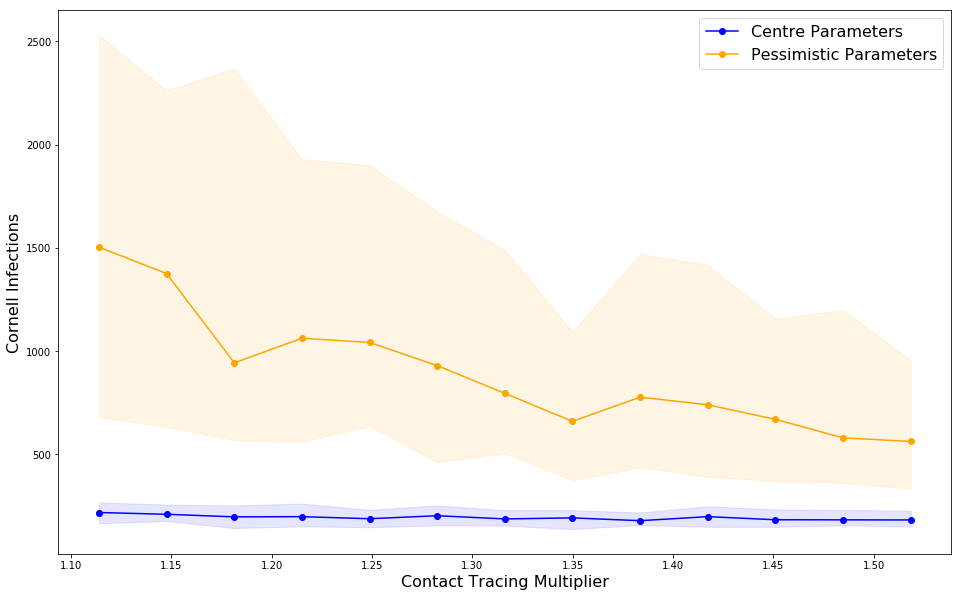

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

xlabels, plot_data = load_plot_data('ct_mult')

plt.figure(figsize=(16,10))

plt.plot(xlabels['centre'], plot_data['centre']['p50'], color='blue', marker='o', label='Centre Parameters')
plt.fill_between(xlabels['centre'], plot_data['centre']['p10'], plot_data['centre']['p90'], alpha=0.1, color='blue')

plt.plot(xlabels['pess'], plot_data['pess']['p50'], color='orange', marker='o', label='Pessimistic Parameters')
plt.fill_between(xlabels['pess'], plot_data['pess']['p10'], plot_data['pess']['p90'], alpha=0.1, color='orange')

plt.xlabel("Contact Tracing Multiplier", fontsize=16)
plt.ylabel("Cornell Infections", fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.show()


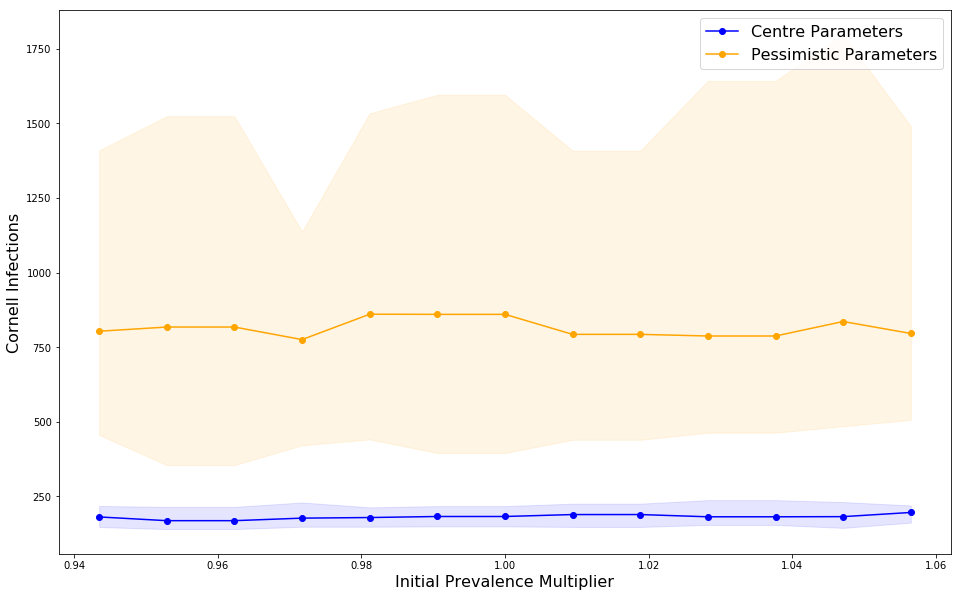

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

xlabels, plot_data = load_plot_data('inital_prev_mult')

plt.figure(figsize=(16,10))

plt.plot(xlabels['centre'], plot_data['centre']['p50'], color='blue', marker='o', label='Centre Parameters')
plt.fill_between(xlabels['centre'], plot_data['centre']['p10'], plot_data['centre']['p90'], alpha=0.1, color='blue')

plt.plot(xlabels['pess'], plot_data['pess']['p50'], color='orange', marker='o', label='Pessimistic Parameters')
plt.fill_between(xlabels['pess'], plot_data['pess']['p10'], plot_data['pess']['p90'], alpha=0.1, color='orange')

plt.xlabel("Initial Prevalence Multiplier", fontsize=16)
plt.ylabel("Cornell Infections", fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.show()


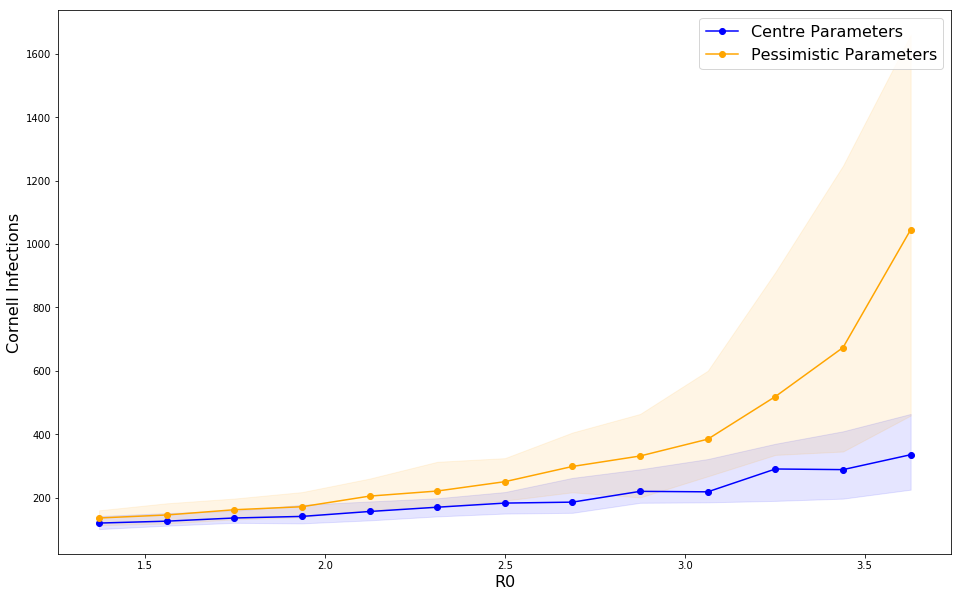

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

xlabels, plot_data = load_plot_data('R0')

plt.figure(figsize=(16,10))

plt.plot(xlabels['centre'], plot_data['centre']['p50'], color='blue', marker='o', label='Centre Parameters')
plt.fill_between(xlabels['centre'], plot_data['centre']['p10'], plot_data['centre']['p90'], alpha=0.1, color='blue')

plt.plot(xlabels['pess'], plot_data['pess']['p50'], color='orange', marker='o', label='Pessimistic Parameters')
plt.fill_between(xlabels['pess'], plot_data['pess']['p10'], plot_data['pess']['p90'], alpha=0.1, color='orange')

plt.xlabel("R0",fontsize=16)
plt.ylabel("Cornell Infections", fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.show()


In [40]:
plot_data

{'centre': {'p10': [167.0,
   178.0,
   143.8,
   151.9,
   148.0,
   156.8,
   155.4,
   138.8,
   158.7,
   149.9,
   149.9,
   157.2,
   151.9],
  'p50': [219.0,
   210.5,
   198.0,
   199.0,
   189.0,
   203.5,
   188.0,
   193.0,
   179.5,
   199.0,
   184.0,
   183.5,
   183.0],
  'p90': [268.3,
   257.40000000000003,
   253.4,
   262.2,
   232.2,
   253.4,
   230.39999999999998,
   230.7,
   219.20000000000005,
   249.20000000000002,
   234.10000000000002,
   231.3,
   228.60000000000002]},
 'pess': {'p10': [682.1,
   632.9000000000001,
   570.6,
   561.5,
   637.6,
   462.1,
   506.59999999999997,
   375.0,
   437.79999999999995,
   393.0,
   370.8,
   362.7,
   332.9],
  'p50': [1503.5,
   1375.5,
   943.5,
   1062.5,
   1042.5,
   930.0,
   796.0,
   660.5,
   777.5,
   740.5,
   670.0,
   580.5,
   563.0],
  'p90': [2531.0,
   2261.2000000000003,
   2369.4,
   1929.4,
   1900.9,
   1676.4,
   1490.1000000000001,
   1093.1000000000001,
   1470.1,
   1417.7000000000003,
   115

In [31]:
sim_fpaths = get_sim_output_fnames('ct_mult')
#sim_results = load_sim_output(sim_fpaths)
for fpath in sim_fpaths:
    print(map_fpath_to_params(fpath))

('pess', 10)
('pess', 6)
('pess', 12)
('centre', 7)
('pess', 11)
('centre', 9)
('pess', 8)
('pess', 9)
('centre', 2)
('centre', 8)
('pess', 3)
('centre', 11)
('pess', 7)
('pess', 5)
('pess', 4)
('centre', 12)
('centre', 3)
('centre', 0)
('pess', 2)
('pess', 1)
('pess', 0)
('centre', 1)
('centre', 10)
('centre', 4)
('centre', 5)
('centre', 6)


In [26]:
sim_fnames[0]

'/home/jmc678/covid_data/group-testing/notebooks/pnas_paper_figs/sensitivity_sims_1620271857//ct_mult/pess_mult_10.dill'

In [22]:
type(sim_results)

pandas.core.frame.DataFrame

In [23]:
sim_results.shape

(26, 28)

In [34]:
sim_results.iloc[0]

asymp_prob_mult                   1.152210
inital_prev_mult                  1.051377
R0                                3.525612
outside_inf_mult                  1.024138
daily_self_report_prob            0.346394
ct_mult                           1.450995
ct_testing_ratio                  0.840888
test_sensitivity                  0.521040
test_noncompliance                0.105169
E_time                            1.978106
ID_time                           3.100160
Sy_time                          11.997462
virtual_noncompliance             0.500000
intermittent_non-compliance       0.500000
virtual_r0_mult                   1.235000
virtual_pop_size                  0.500000
res_cornell_inf_10              370.800000
res_cornell_inf_50              670.000000
res_cornell_inf_90             1156.000000
res_ithaca_inf_10               262.600000
res_ithaca_inf_50               307.000000
res_ithaca_inf_90               362.100000
vir_cornell_inf_10             7641.800000
vir_cornell